In [1]:
# pip install torch transformers --upgrade

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import os
import torch

In [ ]:
# Define Model ID
model_id = "tiiuae/falcon-7b-instruct"
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Load Model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float32,  # ✅ works on all CPUs/GPUs
    trust_remote_code=True
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:

# Function to get embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256).to(model.device)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, return_dict=True)
        last_hidden = outputs.hidden_states[-1]
        mean_pooled = last_hidden.mean(dim=1).squeeze().cpu().numpy()  # (hidden_dim,)
    return mean_pooled

In [ ]:


# Load the original dataset
df = pd.read_csv("pegasus_data.csv")

# Split the dataset by class
class_0_df = df[df['class'] == 0]
class_1_df = df[df['class'] == 1]

# Take 80% of class 0 and 80% of class 1
class_0_sample = class_0_df.sample(frac=0.1, random_state=42)
class_1_sample = class_1_df.sample(frac=0.1, random_state=42)

# Combine the 80% samples of both classes
sampled_df = pd.concat([class_0_sample, class_1_sample])

# Reset index
sampled_df = sampled_df.reset_index(drop=True)



In [ ]:
# Create list for embeddings
embeddings = []

# Generate embeddings for the sampled data
for text in tqdm(sampled_df["cleaned_comment"]):
    try:
        emb = get_embedding(text)
        embeddings.append(emb)
    except Exception as e:
        print("Error:", e)
        embeddings.append(None)

# Add embeddings to the dataframe
sampled_df["embedding"] = embeddings

# Remove any rows with None embeddings (optional)
sampled_df = sampled_df[sampled_df["embedding"].notnull()]

100%|██████████| 369/369 [1:36:11<00:00, 15.64s/it]


In [ ]:
sampled_df.to_csv('sampled_output.csv', index=False)

In [ ]:
class XGBoostClassifier:
    def __init__(self, learning_rate=0.1, n_estimators=100, max_depth=3):
        """
        Initialize XGBoost model with hyperparameters.

        :param learning_rate: Step size for optimization (default 0.1).
        :param n_estimators: Number of boosting rounds (default 100).
        :param max_depth: Maximum depth of the tree (default 3).
        """
        self.model = XGBClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)

    def train_model(self, X_train, y_train):
        """
        Train the XGBoost model.

        :param X_train: Training data features.
        :param y_train: Training data labels.
        """
        self.model.fit(X_train, y_train)

    def predict_data(self, X):
        """
        Predict using the trained XGBoost model.

        :param X: Test data features.
        :return: Predicted labels.
        """
        return self.model.predict(X)

    def evaluate_xgboost_model(self, X_test, y_test):
        """
        Evaluate the XGBoost model and print metrics.

        :param X_test: Test data features.
        :param y_test: Test data labels.
        """
        predictions = self.predict_data(X_test)
        accuracy = accuracy_score(y_test, predictions)
        precision = precision_score(y_test, predictions, average='macro')
        recall = recall_score(y_test, predictions, average='macro')
        f1 = f1_score(y_test, predictions, average='macro')
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
        print("\nDetailed Classification Report:")
        print(classification_report(y_test, predictions))
        cm = confusion_matrix(y_test, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix for XGBoost Model")
        plt.show()


In [ ]:
# Step 1: Extract features (embeddings) and labels
X = np.array(sampled_df['embedding'].tolist())  # Convert list of embeddings to ndarray
y = sampled_df['class'].values

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



Accuracy: 0.7432, Precision: 0.7386, Recall: 0.7092, F1-score: 0.7158

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80        45
           1       0.73      0.55      0.63        29

    accuracy                           0.74        74
   macro avg       0.74      0.71      0.72        74
weighted avg       0.74      0.74      0.73        74



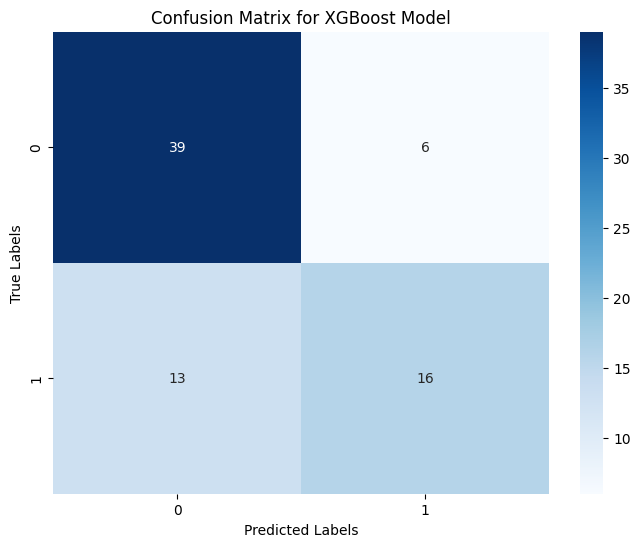

In [ ]:
# Step 3: Train the XGBoost model
xgboost_classifier = XGBoostClassifier(learning_rate=0.05, n_estimators=200, max_depth=5)
xgboost_classifier.train_model(X_train, y_train)

# Step 4: Evaluate on the test set
xgboost_classifier.evaluate_xgboost_model(X_test, y_test)
